 
     OCCUPATIONAL ARCHETYPES 
     Purpose: A tool for people and organizations to discuss, analyze, predict, 
     strategize on the job market. 

     Data Sources:
     - Occupation data: O*NET
     - Demographic data: Census ACS/PUMS

     ## What this codes does
     - Creates occupational archetypes from a matrix of occupations and festures 
       (abilities, skills, knowledge, etc.)
     - Selects a demography from census
     - Calculates labor market statistics, economic indicators for the archetypes 
       with regards to the demography
     - Evaluate the predictive power of the Archtypes: 
           - select a target (yearly full-time equivalent wage)
           - fit features to target: compare Archetypes vs original features. 
    
Example demographic: People in Maine working more than 15 hours per week
*** Onet matrix not in dictionary. Constructing....
*** Complete


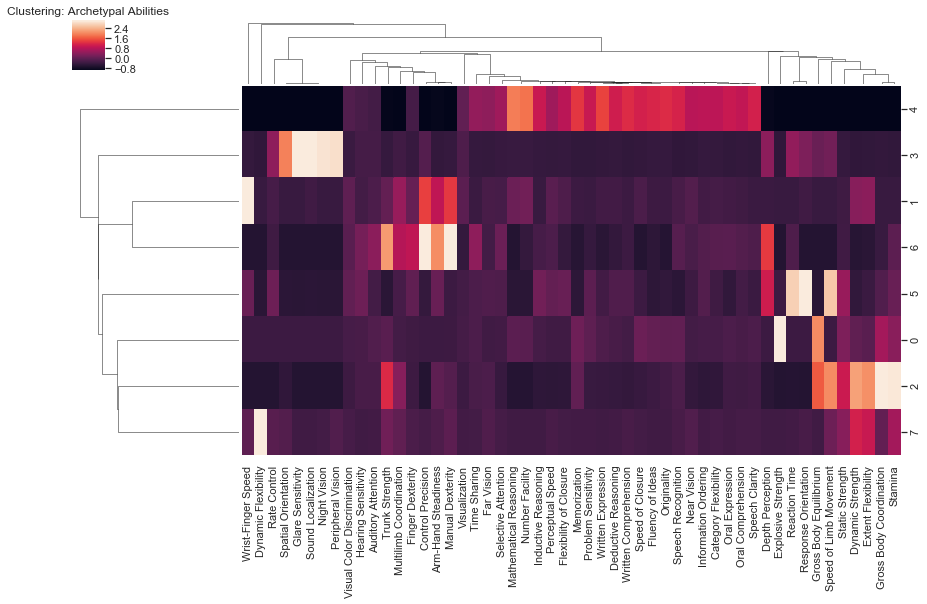

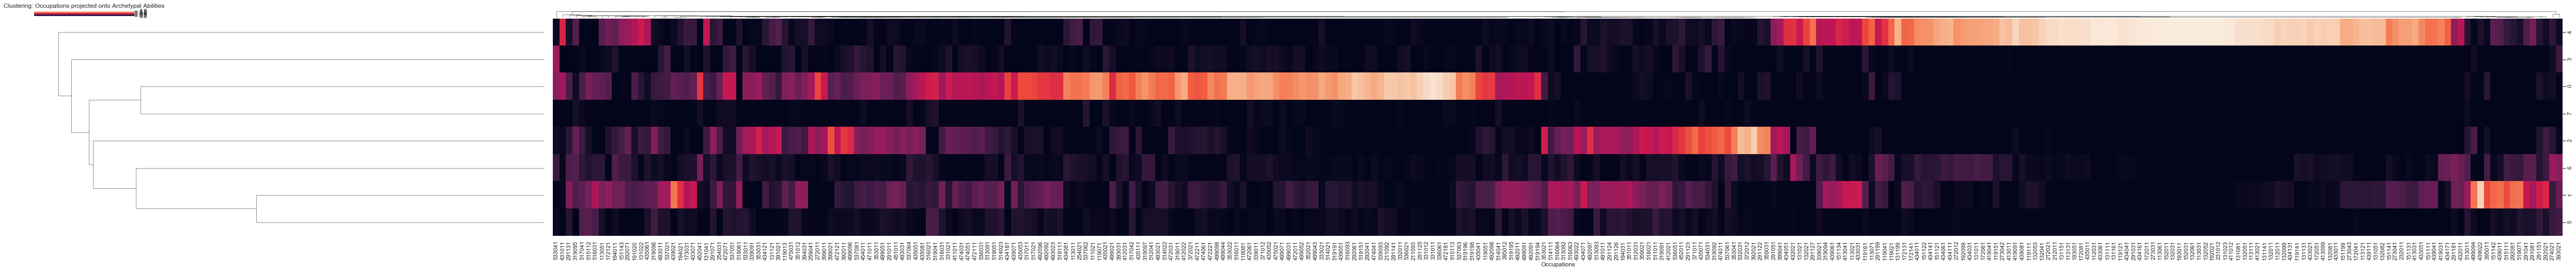

In [46]:
#%%

# IMPORT LIBRARIES

## OS
import os

# MANAGE
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import scipy
import collections

## FIT
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from sklearn.metrics import r2_score

## DECOMPOSITION
from sklearn.decomposition import NMF
from scipy.linalg import svd

## GRAPHICS
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

## I/O
import zipfile
import requests
import pickle

## DOWNLOAD
import urllib.request
from tqdm import tqdm

## NLP
import nltk
lemmatizer = nltk.stem.WordNetLemmatizer()
from nltk.corpus import stopwords
set(stopwords.words('english'))
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)


## CREATE PATHS / DIRECTORIES 

# path to home directory (the location of this file)
path0 = !pwd
path = path0.n

os.chdir(path)

#Check if directories exist - creat directories if needed

paths = {}
paths['data'] = './data'
paths['census'] = paths['data'] + '/census'
paths['onet'] = paths['data'] + '/onet'

[os.makedirs(pth, exist_ok=True) for pth in paths.values()]


## GENERAL FUNCTIONS 
### NORMALIZATION
# Statistic normalization - subtract mean, scale by standard deviation
def norm_stat(vec, weights = False):
    '''
    Normalizes a vector v-v.mean())/v.std() 
    '''
    if weights:
        return  np.mean(abs(vec - vec.mean()))  
    return (vec-vec.mean())/vec.std()

# Algebraic normalization - dot product
def norm_dot(vec, weights = False):
    '''
    Normalizes the columns of a DataFrame (dot product)
    '''
    if weights:
        return  np.sqrt(vec @ vec)
    
    return vec / np.sqrt(vec @ vec)

# Algebraic normalization - dot product
def norm_sum(vec, weights = False):
    '''
    Normalizes the columns of a DataFrame (dot product)
    '''
    if weights:
        return  vec.sum()
    
    return vec / vec.sum()

# 
# Scaled Normalization -
def scale(vec, weights = False):
    stop_divide_by_zero = 0.00000001
    if weights:
        return (vec.max()-vec.min() + stop_divide_by_zero)
    return (vec-vec.min())/(vec.max()-vec.min() + stop_divide_by_zero)



### SELECTION 
def is_string(a):
    '''
    typically used for Boolean masking in Pandas, e.g.  
               df[df['column'].apply(is_string)] 
    returns all rows in df where df['column'] has a string value   
    '''
    return isinstance(a,str)


## CLASSES

### DATA DICTIONARY 

class    Datadic: 
    def __init__(self):
        # Set up FIPS CODES for states and regions
        fips_codes_exists = os.path.isfile('data/state-geocodes-v2016.xls')
        if not fips_codes_exists:
            print('*** FIPS State Geocodes is missing. Downloading from Census...')
            # !curl -o ./data/state-geocodes-v2016.xls -O https://www2.census.gov/programs-surveys/popest/geographies/2016/state-geocodes-v2016.xls
            download_url('https://www2.census.gov/programs-surveys/popest/geographies/2016/state-geocodes-v2016.xls','./data/state-geocodes-v2016.xls')
            print('*** Complete.')

        self.dfips = pd.read_excel('data/state-geocodes-v2016.xls')[5:] #five first rows are comment
        self.name_to_fips = self.dfips.set_index('Unnamed: 3')['Unnamed: 2'].to_dict()
        self.fips_to_name = self.dfips.set_index('Unnamed: 2')['Unnamed: 3'].to_dict()
        self.translate_fips = {**self.name_to_fips,**self.fips_to_name}
        
        self.state_to_abbrev = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO',
                'Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI',
                'Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
                'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO',
                'Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM',
                'New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
                'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX',
                'Utah': 'UT','Vermont': 'VT','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'}
        self.abbrev_to_state = {v: k for k, v in self.state_to_abbrev.items()}
        self.translate_state_abbrev = {**self.state_to_abbrev,**self.abbrev_to_state}
        
        #Set up CENSUS/ACS PUMS DATA DICTIONARY
        pums_datadic_exists = os.path.isfile('./data/census/PUMS_Data_Dictionary.csv')
        if not pums_datadic_exists:
            print('*** Census ACS/PUMS Data Dictionary is missing. Downloading from Census...')
            # !curl -o ./data/census/PUMS_Data_Dictionary.csv -O https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2017.csv
            download_url('https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2017.csv','./data/census/PUMS_Data_Dictionary.csv')
            print('*** Complete.')
        self.census = pd.read_csv("data/census/PUMS_Data_Dictionary.csv").drop_duplicates()
        self.census_variable_definitions = self.census.groupby('RT').first()['Record Type'].to_dict()      
            
    def fips(self,name_or_fipsnr):
        nn = datadic.abbrev_to_state.get(name_or_fipsnr,name_or_fipsnr)
        return self.translate_fips.get(nn)
    
    def state_abbrev(self,name_or_abbrev):
        return self.translate_state_abbrev.get(name_or_abbrev)
    
    def census_def(self,variable_code):
        return self.census_variable_definitions.get(variable_code)

    # All definitions containing a select string
    def clk(self,census_col,search_string):
        return self.census[census_col].fillna('nan').apply(lambda x: search_string.lower() in x.lower())
    
    def census_about(self,search_string):
        return self.census[self.clk('Record Type',search_string) | self.clk('Unnamed: 6',search_string) ]
    
datadic = Datadic()


class Onet:
    '''
    Onet() is an object based on the Onet labor market database. 

    my_onet.source  - string: URL for importing the onet database from source
    my_onet.path    - string: local path to the directory where the onet database is stored. (set in 'paths' dictionary)
    my_onet.name    - string: the prefix of stored files, e.g. zipped DB:      path + '/'+ name +'.zip'
    my_onet.toc()   - function: returns table of contents for onet database

   # Data in Onet database
    my_onet.data()
                    - function: returns dataset named by label.
    my_onet.matrix() 
                    - function: returns onet dataset in matrix form
    my_onet.n_matrix() 
                    - function: normalized onet matrix
 
   
    '''
    def __init__(self,path = paths['onet'], name = 'onet', source = 'https://www.onetcenter.org/dl_files/database/db_23_3_excel.zip'):
        
        self.path = path
        self.name = name
        self.source = source
        self.dataset = {}
        self.matrix_dic = {}

        self.socp_titles = self.data('Alternate Titles',socp_shave = 8)[['SOCP_shave','Title']].drop_duplicates()
        
        zip_file = path + '/'+ name +'.zip'
        onet_exists = os.path.isfile(zip_file)
        if not onet_exists:
            print('*** Onet database does not exist. Downloading from Onet...')
            #shcmd = 'curl -o '+zip_file+' -O '+source
            #!$shcmd'
            download_url(source,zip_file)
            print('*** Complete.')
        
        self.zip = zipfile.ZipFile(zip_file)
        self.tocdf = self.make_toc()
    
    def make_toc(self,sep ='.'):
        '''
        Creates table of contents for Onet Database, returns as my_onet.tocdf (dataframe)
        '''
        nlst = np.array(self.zip.namelist())
        dr = nlst[0]
        nl = pd.DataFrame(nlst)
        self.tocdf = pd.DataFrame(nl[0].apply(lambda x: np.char.split(x.replace(dr,''),sep = '.'))[1:].to_dict(),
                                    index = ['name','extension']).T
        return self.tocdf
    
    def toc(self, name_contains= False, extension = False):
        '''
        Returns table of contents for Onet Database (dataframe) masked by string and/or extension
        '''
        selection = self.tocdf
        if extension:
            selection = selection[selection['extension'] == extension  ]['name']
        if name_contains:
            search_string = name_contains
            selection = selection[selection['name'].apply(lambda x: search_string.lower() in x.lower())]['name']
        return selection
         
    
    def data(self,label, socp_shave = 6):
        '''
        Returns onet dataset named 'label'
        '''
        # If dataframe in dictionary:  
        if label in self.dataset.keys():
            df = self.dataset[label]
            df['SOCP_shave'] = df['O*NET-SOC Code'].apply(lambda x: x.replace('.','').replace('-','')).apply(lambda x: x[:socp_shave])
            return self.dataset[label]

        # If dataframe NOT in dictionary: 
        # If pickled dataframe does not exist, create from zipped excel
        # Read pickled dataframe into dictionary
        pkl_name = self.path +'/'+ self.name +'_'+ label +'.pkl'
        pkl_exists = os.path.isfile(pkl_name)

        if not pkl_exists:
            print('*** '+label+'.pkl does not exist. Creating...')
            xlsx_name = self.zip.namelist()[0] + label +'.xlsx'
            pd.read_excel(self.zip.extract(xlsx_name)).to_pickle(pkl_name)
            print('*** Complete.')
        df = pd.read_pickle(pkl_name)
        df['SOCP_shave'] = df['O*NET-SOC Code'].apply(lambda x: x.replace('.','').replace('-','')).apply(lambda x: x[:socp_shave])
        self.dataset[label] = df                              
        return self.dataset[label]
    
    def grpby(self, label, columns = ['Scale Name','Element Name'], data_value = 'Data Value', scale_name = 'Level'):
        grp = pd.DataFrame(self.data(label).copy().groupby(columns).apply(lambda x: x[data_value].values))
        return grp

    def matrix(self,label, xx = 'Element Name',  yy = 'SOCP_shave',socp_shave = 6 , data_value = 'Data Value', scale_name = 'Level',
                show = 'mean', norm = False):
        '''
        Converts onet dataset into a matrix 
        xx          - matrix columns
        yy          - matrix index
        scale_name  - value category 
        data_value  - data values
        socp_shave  - number of digits in 'shaved' SOCP number
        show        - output matrix shows 'mean'(default), 'std' or 'count' (relevant for groupby socp_shave)
        norm        - columns are normalized: 'norm = norm_dot'  [ col/sqrt(col@col) ] 
                                              'norm = norm_stat' [ (col - col.mean) / col.std ] 
                                         
        '''
        if not (label,xx,yy,socp_shave,data_value,scale_name,norm) in self.matrix_dic.keys():
            print('*** Onet matrix not in dictionary. Constructing....')
            columns = ['Scale Name',yy,xx] # Default columns
            grpb = self.data(label,socp_shave = socp_shave).groupby(columns)
            mat_mean   = grpb.mean().loc[scale_name][data_value].unstack()
            mat_std    = grpb.std().loc[scale_name][data_value].unstack()
            mat_count = grpb.count().loc[scale_name][data_value].unstack().T.iloc[[0]].T
            if norm:
                w = mat_mean.apply(lambda col: norm(col,weights = True) )
                mat_mean = mat_mean.apply(norm)
                mat_std = mat_std/w
            self.matrix_dic[label,xx,yy,socp_shave,data_value,scale_name,norm] = {
                'mean':mat_mean,'std':mat_std,'count':mat_count}
            print('*** Complete')
        return self.matrix_dic[label,xx,yy,socp_shave,data_value,scale_name,norm][show]
    
       
# Instantiate Onet() as 'onet'
onet = Onet()            

#%%    

class   Census:
    '''
    Census() is an object containing census ACS/PUMS data 
    my_census.source    - string: URL for importing the census data from US Census online
    my_census.path      - string: local path to the directory where the census data is stored. (set in 'paths' dictionary)
    my_census.name      - string: the prefix of stored files, e.g. pickle:      path + '/'+ name +'.pkl'

    my_census.data(self,state, socp_shave = n)
                        - function: returns the acs/pums for 'state', with an SOCP number of 'n' digits (default n=6)
    my_census.dataset   - dataframe: acs/pums data for a state (state abbreviation used for naming)
    my_census.import_from_source(self,state)
                        - function: imports data for 'state' from my_census.source and converts to pickled dataframe 


    # my_census.state    – String: name of state, e.g. 'California', or abbreviation, e.g. 'CA'
    # my_census.data     – DataFrame: imported census ACS/PUMS data (from pickle)
    # my_census.workers  – DataFrame: people fulfilling 'workers' criteria (see below)
    # my_census.occupations         – DataFrame: Occupations of the workers (groupby SOCP-number)
    
    # my_census.workers_occupations(age_low = 40, age_high = 65, std_max = 0.5, socp_granularity = 5):
    #      - Function: populates my_census.workers / .occupations according to criteria
    #          – Workers: age_low (default 40)  and age_high (default 65)
    #          – Occupations: socp_granularity (default 5) ; the length of the SOCP number, default 5 digits.
    
    '''

    def __init__(self,path = paths['census'], 
                 name = 'census', 
                 source = 'https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/'):
        self.path = path
        self.name = name
        self.source = source
        self.dataset = {}
        
    
    def data(self,state, socp_shave = 6):
        '''
        READ CENSUS/ACS PUMS DATABASE. Search order: Dictionary, Pickle; Create dictionary/pickle if non-existent.
        socp_shave  : number of digits in 'shaved' SOCP number
        '''
        state_abbr = datadic.state_to_abbrev.get(state,state)
        pkl_name = self.path +'/'+ self.name +'_'+ state_abbr +'.pkl'
        pkl_exists = os.path.isfile(pkl_name)
        if not pkl_exists:
            self.import_from_source(state)
        df = pd.read_pickle(pkl_name)
        df['SOCP_shave'] = df['SOCP'].apply(lambda x: x[:socp_shave].replace('X','0') if type(x)==str else x)
        self.dataset[state_abbr] = df
        return self.dataset[state_abbr]


    # Create and execute shell command fetching state census zip-file 
    def import_from_source(self,state):
        '''
        Imports ACS/PUMS dataset from US Census online, URL: my_census.source
        '''
        print('*** Downloading '+state+' ACS/PUMS dataset from US Census...')
        state_abbr = datadic.state_to_abbrev.get(state,state)
 #       shcmd = "curl -o "+self.path+'/'+self.name+"_tmp.zip -O "+ self.source +self.state_zipfile_name(state_abbr)
 #       ! $shcmd
        download_url(self.source +self.state_zipfile_name(state_abbr),self.path+'/'+self.name+"_tmp.zip")
        print('*** Reformatting...')
        with zipfile.ZipFile(self.path+'/'+self.name+"_tmp.zip", 'r') as zipObj:
            zipObj.extractall(self.path)
        csv_filename = self.path+'/psam_p'+datadic.fips(state)+'.csv'
        pkl_filename = self.path+'/'+self.name+'_'+state_abbr+'.pkl'
        pd.read_csv(csv_filename).to_pickle(pkl_filename)
        ! rm $csv_filename 
        print('*** Complete.')
        return 

    def state_zipfile_name(self,state_abbr):
        '''
        Input: State name abbreviation. Returns census-convention name of zipped csv-file
        '''
        return 'csv_p'+state_abbr.lower()+'.zip'
    

# Instantiate Census() as 'census'
census = Census()

# # Xy - matrix
class MakeXy:
    '''
    MakeXy is an object containing a combination of census and onet data
    
    my_makeXy = MakeXy(my_census,my_onet)
    
    my_makeXy.Xy     : Merges my_census and my_onet with 'SOCP_shave' (occupational code)
                                as common variable and my_census[y_label] as target variable, and groups: 
                                my_make.Xy(y_label) = merged.groupby('SOCP_shave').sum() 
    my_makeXy.X      : X-matrix / independent variables
    my_makeXy.y      : y-matrix / target
    
    '''
    def __init__(self,census,onet,y_label = 'fte'):
        self.census  = census
        self.onet    = onet
        self.y_label = y_label
        merged       = pd.merge(self.census[['SOCP_shave',self.y_label]],self.onet,
                         left_on = 'SOCP_shave',right_index=True)
        self.Xy =  merged.groupby('SOCP_shave').sum()
        self.X  =  self.Xy.drop(self.y_label, axis =1)
        self.y  =  self.Xy[self.y_label]


    
class Xyzzy:
    
    def __init__(self,
            state,
            state_cols = ['WAGP','WKHP'],
            fte        = {'fulltime':40,'min_hours':15,'min_fte':0}, 
            y_label    = 'fte',
            X_label    = 'Abilities',
            socp_shave = 6,
            norm       = norm_dot
             ):
        '''
        MakeXy / Archetypes wizard. 
        '''
        self.state = state
        self.y_label = y_label
        self.X_label = X_label
        self.socp_shave = socp_shave
        self.fte     = fte
        
        census_cols = ['SOCP_shave'] + state_cols
        self.cols   = census_cols
        
        self.census   = census.data(self.state,  socp_shave = socp_shave)[self.cols]
        self.onet     = onet.matrix(self.X_label,socp_shave = socp_shave, norm = norm)
        if fte:
            c0 = self.census.dropna()
            c1 =  c0[
                            c0['WKHP'] >= fte['min_hours']
                            ]
            c1['fte'] = fte['fulltime']*c1['WAGP']/c1['WKHP']
            self.census = c1[c1['fte']>=fte['min_fte']] 
        self.make_Xy = MakeXy(self.census,self.onet,y_label = self.y_label)
        self.X = self.make_Xy.X
        self.y = self.make_Xy.y
        self.Xy = self.make_Xy.Xy
        self.archetypes_dic ={}       
        
    def archetypes(self,n,norm=norm_dot):
        if n not in self.archetypes_dic.keys():
            self.archetypes_dic[(n,norm)] = Archetypes(self.X,n,norm=norm)
        return self.archetypes_dic[(n,norm)]

    
# # MATRIX-FACTORIZATION: DIMENSIONALITY REDUCTION & ARCHETYPING

# ## CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# ## Use non-zero matrix factorization for clustering
# ## Use singular value decomposition first state for determining overall similarity


class Archetypes:
    '''
    Archetypes: Performs NMF of order n on X and stores the result as attributes. 
    Archetypes are normalized: cosine similarity a(i) @ a(i) = 1. 
    Atributes:
        my_archetypes.n         - order / number of archetypes
        my_archetypes.X         - input matrix
        
        my_archetypes.model     - NMF model 
        my_archetypes.w         - NMF w-matrix 
        my_archetypes.h         - NMF h-matrix
        
        my_archetypes.o         - occupations x archetypes matrix (from w-matrix)
        my_archetypes.on        - occupations x normalized archetypes matrix (from w-matrix) - SOCP number as index. 
        my_archetypes.occ       - occupations x normalized archetypes matrix - Occupation names as index
        
        my_archetypes.f         - features x archetypes matrix (from h-matrix)
        my_archetypes.fn        - features x normalized archetypes matrix
        
    '''
    def __init__(self,X,n,norm = norm_dot):
        self.n = n
        self.X = X
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w = self.model.fit_transform(self.X)
        self.o = pd.DataFrame(self.w,index=self.X.index)
        self.on = self.o.T.apply(norm).T
        self.occ = self.on.copy()
        self.occ['Occupations'] = self.occ.index
#        self.occ['Occupations'] = self.occ['Occupations'].apply(onet_socp_name)
        self.occ = self.occ.set_index('Occupations')
        self.h = self.model.components_
        self.f = pd.DataFrame(self.h,columns=X.columns)
        self.fn =self.f.T.apply(norm).T
        self.plot_occupations_dic ={}
        self.plot_features_dic ={}
        
    def plot_features(self,fig_scale = (1,3.5),metric='cosine', method = 'single',vertical = False): 
        '''
        Plot Archetypes as x and features as y. 
        Utilizes Seaborn Clustermap, with hierarchical clustering along both axes. 
        This clusters features and archetypes in a way that visualizes similarities and diffferences
        between the archetypes. 
        
        Archetypes are normalized (cosine-similarity): dot product archetype[i] @ archetype[i] = 1.
        The plot shows intensities (= squared feature coefficients) so that the sum of intensities = 1.  

        fig_scale: default values (x/1, y/3.5) scales the axes so that all feature labels are included in the plot.
        
        For other hyperparameters, see seaborn.clustermap
     
        '''
        param = (fig_scale,metric,method,vertical)
        if param in self.plot_features_dic.keys():
            fig = self.plot_features_dic[param]
            return fig.fig

        df = np.square(self.fn)

        if vertical:
            fig = sns.clustermap(df.T,robust = True, z_score=1,figsize=(
                self.n/fig_scale[0],self.X.shape[1]/fig_scale[1]),method = method,metric = metric)        
        else: # horizontal
            fig = sns.clustermap(df,robust = True, z_score=0,figsize=(
                self.X.shape[1]/fig_scale[1],self.n/fig_scale[0]),method = method,metric = metric)        
        self.features_plot = fig
        return fig


    def plot_occupations(self,fig_scale = (1,3.5),metric='cosine', method = 'single',vertical = False):
        '''
        Plot Archetypes as x and occupations as y. 
        Utilizes Seaborn Clustermap, with hierarchical clustering along both axes. 
        This clusters occupations and archetypes in a way that visualizes similarities and diffferences
        between the archetypes. 
        
        Occupations are normalized (cosine-similarity): dot product occupation[i] @ occupation[i] = 1.
        The plot shows intensities (= squared feature coefficients) so that the sum of intensities = 1.  

        fig_scale: default values (x/1, y/3.5) scales the axes so that all feature labels are included in the plot.
        
        For other hyperparameters, see seaborn.clustermap
     
        '''
        param = (fig_scale,metric,method,vertical)
        if param in self.plot_occupations_dic.keys():
            fig = self.plot_occupations_dic[param]
            return
            #return fig.fig

        df = np.square(self.occ)
        if vertical:
            fig = sns.clustermap(df, figsize=(
                self.n/fig_scale[0],self.X.shape[0]/fig_scale[1]),method = method,metric = metric)
        else: # horizontal
            fig = sns.clustermap(df.T, figsize=(
                self.X.shape[0]/fig_scale[1],self.n/fig_scale[0]),method = method,metric = metric)
        self.plot_occupations_dic[param] = fig
        return
        #return fig.fig

        
class Xfit:
    '''
    Xfit is a 'fit-as-an-object' solution:
        my_fit = Xfit(X,y,Xsamples=False, my_regressor, itr, xval) 
            does the following:
            0. SAMPLES X - unless Xsamples is 'False' [default value], X is replaced by n random samples of itself  
            1. SPLITS X and y into test and training sets. 
            2. FITS a cross-validation, slicing the training data into 'xval' slices : cross_validate(regressor,X_train.values, y_train.values, cv=xval) 
            3. BOOTSTRAPS: Repeats (1-2) 'itr' number of times
            4. RETURNS RESULTS as attributes:
                my_fit.X          – List: The original X input data
                my_fit.itr        – Number of iterations / fits
                my_fit.y          – List: The original y input data
                my_fit.xval       – Number of slices in the cross validation
                my_fit.fit        – Dictionary: the 'itr' number of cross-validated fits, including estimators
                my_fit.y_test     – Dictionary: the y_test (list) for each fit
                my_fit.y_predict  – Dictionary: the predicted y for each fit
                my_fit.scores     – Pandas.DataFrame: validation scores for all fits 
                my_fit.score      – Dictionary: the mean score and standard deviation. 
                my_fit.features_importances        – Dictionary: feature_importances for all fits (for estimators with '.feature_importance_' as an attribute )
                my_fit.feature_importance          – Pandas.DataFrame: the average feature importances and standard deviations.           
    '''
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import cross_val_score
    from sklearn import linear_model
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    import xgboost as xgb  

    def __init__(self,X,y,Xsamples=False,regressor = xgb.XGBRegressor(),itr = 10, xval = 3):      
        # FITTING
        n = xval  
        feature_names = X.columns
        res = {}
        ypred = {}
        ytest = {}
        scor = {}
        feat_imp = {}       
        for i in range(itr):
            if Xsamples:
                X_train, X_test, y_train, y_test = train_test_split(X.sample(Xsamples,axis=1), y, test_size=0.2)
            else:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            res_xboo = cross_validate(regressor,X_train.values, y_train.values, cv=n, return_estimator=True)
            ytest[i] = y_test
            res[i] = res_xboo
            ypred[i] = [res_xboo['estimator'][j].predict(X_test.values) for j in range(n)]
            scor[i] = [res_xboo['estimator'][j].score(X_test.values,y_test.values) for j in range(n)]
            feat_imp[i] = [res_xboo['estimator'][j].feature_importances_ for j in range(n)]
        scor_tot = np.concatenate(np.array(list(scor.values())))
        feat_tot = pd.concat([pd.DataFrame(feat_imp[i]) for i in range(itr)])
#       # feat_tot.columns = X.columns
        feat_tot.reset_index(inplace=True,drop = True)
        feat_mean = pd.concat([feat_tot.mean(),feat_tot.std()],axis=1)
        feat_mean.columns = ['mean','std']
        feat_mean['ratio'] = feat_mean['std']/feat_mean['mean']      
        # STORING RESULTS AS ATTRIBUTES
        self.X = X
        self.y = y
        self.fit = res
        self.y_predict = ypred
        self.y_test = ytest
        self.scores = pd.DataFrame(scor).T
        self.score = {'mean':scor_tot.mean(), 'std':scor_tot.std()}
        self.feature_importances = feat_imp
        self.feature_importance = feat_mean.sort_values('mean',ascending=False)
        self.itr =itr
        self.xv = xval



class Svd:
    ''''
    Singular value decomposition-as-an-object
        my_svd = Svd(X) returns
        my_svd.u/.s/.vt – U S and VT from the Singular Value Decomposition (see manual)
        my_svd.f        – Pandas.DataFrame: f=original features x svd_features
        my_svd.o        - Pandas.DataFrame: o=occupations x svd_features
        my_svd.volume(keep_volume) 
                        - collections.namedtuple ('dotted dicionary'): 
                          Dimensionality reduction. keeps 'keep_volume' of total variance
                          
                          
    '''
    def __init__(self,X):
        self.u,self.s,self.vt = svd(np.array(X))
        self.f = pd.DataFrame(self.vt,columns=X.columns)
        self.o = pd.DataFrame(self.u,columns=X.index)
        
    def volume(self,keep_volume):
        ''' 
        Dimensionality reduction, keeps 'keep_volume' proportion of original variance
        Type: collections.namedtuple ('dotted dictionary')
        Examples of usage:
        my_svd.volume(0.9).s - np.array: eigenvalues for 90% variance 
        my_svd.volume(0.8).f - dataframe: features for 80% variance
        my_svd.volume(0.5).o - dataframe: occupations for 50% variance      
        '''
        dotted_dic = collections.namedtuple('dotted_dic', 's f o')
        a1 = self.s.cumsum()
        a2 = a1/a1[-1]
        n_max = np.argmin(np.square(a2 - keep_volume))
        cut_dic = dotted_dic(s= self.s[:n_max],f= self.f.iloc[:n_max], o= self.o.iloc[:n_max])
        return cut_dic
        


## NLP UNDER DEVELOPMENT #################

def drop_stopwords(wordvec,language='English'):
    wv = np.array(wordvec)
    stw = np.array(stopwords.words(language))
    without_stopwords = wv[[not word in stw for word in wv]]
    return without_stopwords

def lemmatize(wordvec):
    return [lemmatizer.lemmatize(word) for word in wordvec ]

def nlp_prep(string):
    wordvec = tokenizer.tokenize(string.lower())
    return np.array(lemmatize(drop_stopwords(wordvec)))


#def word_matrix(df_col):

    



title_vec = onet.socp_titles['Title'].apply(nlp_prep)
onet.socp_titles['title_vec'] = title_vec
onet.socp_titles['title_vec']

tt = onet.socp_titles.set_index('SOCP_shave')[['title_vec']]
keywords = np.array(list(set(tt['title_vec'].apply(list).sum())))
df = pd.DataFrame(index = keywords, columns = tt.index)
for socp,keyw in tt['title_vec'].to_dict().items():
    df[socp].loc[keyw]=1
sp = scipy.sparse.csr_matrix(df.fillna(0))


#######################


#%%
if __name__ == "__main__":  
   
    abstract = ''' 
     OCCUPATIONAL ARCHETYPES 
     Purpose: A tool for people and organizations to discuss, analyze, predict, 
     strategize on the job market. 

     Data Sources:
     - Occupation data: O*NET
     - Demographic data: Census ACS/PUMS

     ## What this codes does
     - Creates occupational archetypes from a matrix of occupations and festures 
       (abilities, skills, knowledge, etc.)
     - Selects a demography from census
     - Calculates labor market statistics, economic indicators for the archetypes 
       with regards to the demography
     - Evaluate the predictive power of the Archtypes: 
           - select a target (yearly full-time equivalent wage)
           - fit features to target: compare Archetypes vs original features. 
    ''' 

    print(abstract)
 

    print('Example demographic: People in Maine working more than 15 hours per week')

    xy = Xyzzy('Maine', 
                y_label  = 'fte',
                X_label  ='Abilities',  
                fte      ={'fulltime': 40, 'min_hours': 15, 'min_fte': 0},  
                socp_shave=6
              )

    xy.archetypes(8).plot_features()
    plt.title('Clustering: Archetypal Abilities')
    plt.show()

    xy.archetypes(8).plot_occupations()
    plt.title('Clustering: Occupations projected onto Archetypal Abilities')
    plt.show()

csv_pil.zip: 0.00B [00:00, ?B/s]

*** Downloading Illinois ACS/PUMS dataset from US Census...


csv_pil.zip: 100MB [02:12, 759kB/s]  


*** Reformatting...
*** Complete.
*** Onet matrix not in dictionary. Constructing....
*** Complete


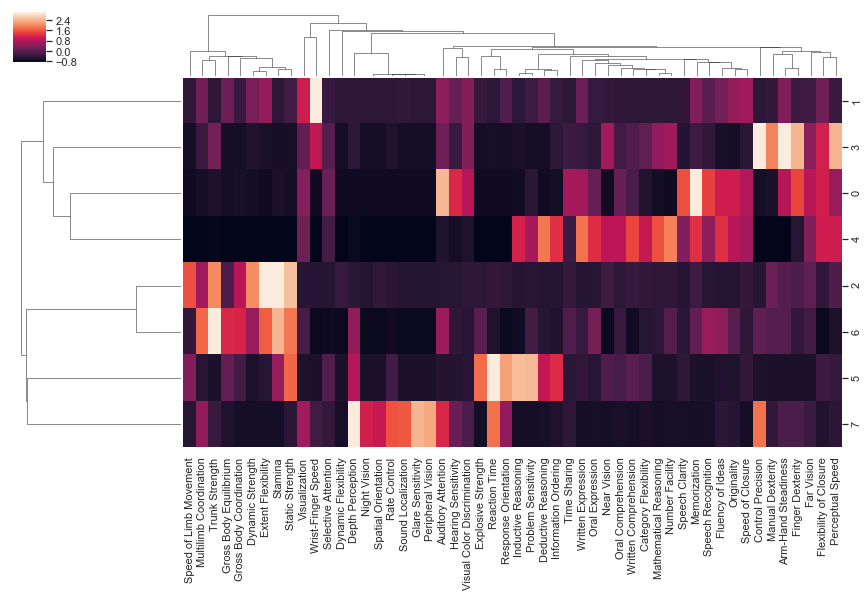

In [40]:
Xyzzy(state='Illinois',onet_set='Abilities',norm=scale).archetypes(8).plot_features(vertical=False)

*** Onet matrix not in dictionary. Constructing....
*** Complete


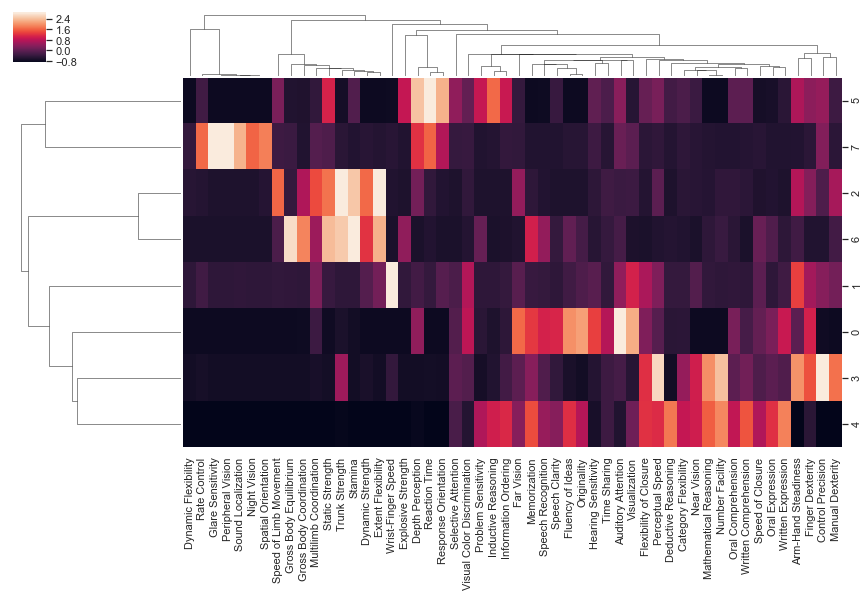

In [4]:
Xyzzy(state='California',onet_set='Abilities',norm=scale).archetypes(8).plot_features(vertical=False)

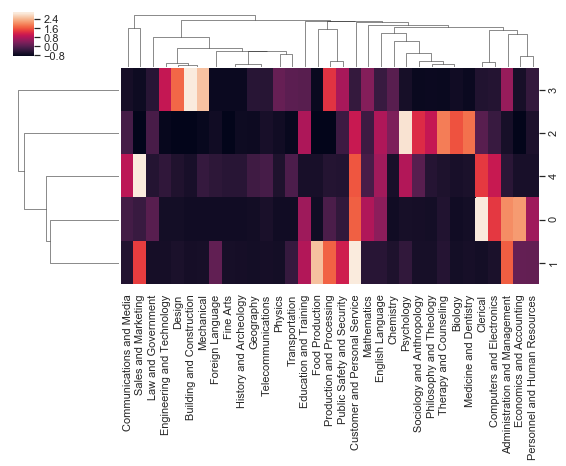

In [28]:
Xyzzy(state='Maine',onet_set='Knowledge',norm=scale).archetypes(5,norm=scale).plot_features(vertical=False)

In [19]:
bab = Svd(onet.matrix('Abilities',norm=norm_dot))

*** Onet matrix not in dictionary. Constructing....
*** Complete


In [20]:
aaab = MakeXy(census.data('California')[['SOCP_shave','WAGP']],bab.o.T)

In [21]:
bbbb = aaab.X(y_label = 'WAGP')

In [22]:
bbbb.head()

,0,1,2,3,4,5,6,7,8,9,...,763,764,765,766,767,768,769,770,771,772
SOCP_shave,,,,,,,,,,,,,,,,,,,,,
111021,354.856504,113.558528,335.513776,344.752065,294.758293,338.766255,153.713013,286.520231,355.671712,134.690545,...,-154.286979,-277.251035,-111.729340,-132.195721,-174.100183,-200.754207,-211.540891,-286.048459,-262.421035,-308.129688
112011,-6.727968,-4.274554,-4.157812,-4.600702,-9.591714,-4.339393,-7.170504,-2.421252,-5.749952,-4.157947,...,6.777480,12.489668,18.002702,14.960097,-11.551648,-9.756732,13.745195,-14.798526,-2.527199,-12.201777
112031,-2.549939,-2.169135,-1.171922,-0.452591,-0.176682,2.089390,-13.603597,-10.420202,0.591158,-8.775178,...,25.252651,-3.457134,-18.343749,13.966843,-11.594871,20.882912,10.718511,12.467431,-22.175581,27.981499
113011,-19.661366,-31.277321,-21.454528,-39.726917,-27.829893,-38.273536,42.445566,15.775152,-42.022331,-26.660670,...,8.979123,0.392036,-69.498807,19.371114,-27.991250,-48.439956,-30.979310,9.456362,-30.596994,-47.626625
113021,85.882879,17.582638,109.459085,171.570248,66.227814,-0.180323,-74.371466,62.912766,147.614394,87.752064,...,-83.999711,-104.621348,-26.046134,-57.848026,-8.671262,128.330952,-158.283035,-241.297076,-276.922921,51.610968


In [23]:
a1 = (ara.fn @ sva.f.T)
sns.heatmap(a1 @ a1.T)

NameError: name 'ara' is not defined

In [37]:
aaa = Xyzzy('California',onet_set='Abilities',norm=norm_dot)

*** Matrix not in dictionary. Constructing....
*** Complete


In [94]:
sva = Svd(aaa.X('fte'))
sva.volume(0.8).o

SOCP_shave,111021,112011,112031,113011,113021,113031,113051,113061,113071,113111,...,536031,536051,536061,537021,537051,537061,537062,537063,537064,537081
0,-0.098034,0.028704,-0.085472,0.116864,-0.115285,-0.084743,0.034533,-0.052751,0.163936,-0.049212,...,-0.021348,0.004495,0.001136,-0.002555,-0.045786,0.028225,-0.074524,0.001242,0.002064,0.009994
1,-0.004707,0.008350,-0.006467,-0.000788,-0.000305,0.003556,0.000211,0.004366,0.004097,-0.010855,...,-0.011611,0.005512,0.001873,0.003908,0.007519,0.098301,0.052918,0.003761,0.091653,-0.014963
2,-0.005237,0.009498,-0.007013,-0.001220,-0.004128,0.002758,-0.000045,0.005487,0.003803,-0.014237,...,-0.003743,0.014807,0.007068,0.012146,0.182696,-0.023111,0.039035,0.002589,-0.126255,-0.003429
3,-0.017071,0.009180,-0.020096,0.019727,-0.008798,-0.019900,-0.017713,-0.029092,-0.017410,-0.015883,...,0.015871,0.006615,0.002620,-0.004733,-0.083672,-0.136801,-0.358055,-0.007057,-0.032928,-0.005639
4,-0.059347,0.079155,-0.068449,-0.012092,0.132361,0.021041,-0.009147,-0.068406,-0.030222,-0.052134,...,-0.006475,0.008597,0.006214,-0.012059,-0.006337,-0.120200,0.032123,0.004140,-0.028031,0.022080
5,-0.097381,0.189664,-0.148955,-0.022224,-0.112199,0.085047,-0.036896,0.087315,0.084717,0.140811,...,0.022685,0.004520,0.003294,-0.003188,-0.062603,-0.091693,0.088654,0.005444,0.083295,0.026111
6,-0.030398,0.009053,-0.033252,0.018023,0.039940,-0.020174,0.019999,-0.036303,0.016037,0.009628,...,-0.015884,-0.015903,-0.003739,-0.015197,-0.070443,-0.041410,0.465910,-0.001558,0.133293,-0.023812
7,-0.016505,0.030793,-0.023605,-0.002275,-0.022285,0.007651,0.001735,0.012428,0.016853,-0.022708,...,-0.008898,0.001768,-0.004417,0.001186,-0.065504,-0.076485,0.004464,0.002393,-0.105352,-0.056347


In [70]:
self = Svd(aaa.X('fte'))
keep_volume = 0.8
a1 = self.s.cumsum()
a2 = a1/a1[-1]
n_max = np.argmin(np.square(a2 - keep_volume))
n_max
cut_dic = {'s': self.s[:n_max],'f': self.f.iloc[:n_max], 'o': self.o.iloc[:n_max]}


,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,Explosive Strength,Extent Flexibility,...,Speed of Limb Movement,Stamina,Static Strength,Time Sharing,Trunk Strength,Visual Color Discrimination,Visualization,Wrist-Finger Speed,Written Comprehension,Written Expression
0,-0.138985,-0.151530,-0.155509,-0.116730,-0.153535,-0.118346,-0.082901,-0.147502,-0.136020,-0.143078,...,-0.123005,-0.164297,-0.152548,-0.161747,-0.160006,-0.147403,-0.140400,-0.102397,-0.153065,-0.152262
1,-0.078278,0.002877,0.101060,-0.105968,0.119712,-0.103524,-0.278783,-0.175085,-0.116492,-0.194199,...,-0.200325,-0.190286,-0.190368,0.065937,-0.115299,0.019949,0.044168,-0.072778,0.118646,0.150154
2,0.115358,0.009586,-0.052148,-0.000248,-0.057074,-0.072647,-0.206962,0.147039,0.295418,0.177091,...,0.063220,0.234378,0.138528,0.008777,0.152770,-0.005377,-0.063617,-0.026547,-0.059800,-0.036167
3,-0.058793,0.025134,-0.038813,-0.014758,0.010046,0.091630,-0.352233,-0.173987,0.648112,-0.162904,...,-0.082623,-0.125839,0.027133,-0.033473,-0.212652,0.025868,0.012327,0.175101,-0.038129,0.031971
4,0.210685,-0.001114,-0.013954,0.253662,-0.017203,0.001086,-0.198486,0.084664,-0.223681,0.118173,...,-0.044240,-0.218013,-0.093761,-0.086861,-0.004640,0.073526,0.077106,0.685820,-0.043201,-0.021989
5,-0.097779,-0.112444,0.057529,-0.050751,0.031274,-0.049327,0.720096,0.000138,0.254038,-0.016384,...,0.011918,0.012664,0.039190,-0.042462,-0.102857,-0.020980,-0.048368,0.192606,0.079318,-0.020010
6,0.064502,0.000598,0.009660,-0.078159,0.056192,0.260397,-0.191756,-0.089510,-0.300844,-0.085938,...,0.419325,0.065483,0.069046,0.049800,-0.116136,0.044048,0.031254,-0.175013,0.064168,0.037310
7,-0.191681,-0.115236,-0.043872,-0.457561,0.077972,-0.213910,-0.068709,0.228292,-0.170528,0.247843,...,0.277106,0.059905,0.045687,-0.097199,-0.152643,-0.057749,0.030625,0.330271,-0.004922,0.078198


In [66]:
self.f.iloc[:n_max]

,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,Explosive Strength,Extent Flexibility,...,Speed of Limb Movement,Stamina,Static Strength,Time Sharing,Trunk Strength,Visual Color Discrimination,Visualization,Wrist-Finger Speed,Written Comprehension,Written Expression
0,-0.138985,-0.151530,-0.155509,-0.116730,-0.153535,-0.118346,-0.082901,-0.147502,-0.136020,-0.143078,...,-0.123005,-0.164297,-0.152548,-0.161747,-0.160006,-0.147403,-0.140400,-0.102397,-0.153065,-0.152262
1,-0.078278,0.002877,0.101060,-0.105968,0.119712,-0.103524,-0.278783,-0.175085,-0.116492,-0.194199,...,-0.200325,-0.190286,-0.190368,0.065937,-0.115299,0.019949,0.044168,-0.072778,0.118646,0.150154
2,0.115358,0.009586,-0.052148,-0.000248,-0.057074,-0.072647,-0.206962,0.147039,0.295418,0.177091,...,0.063220,0.234378,0.138528,0.008777,0.152770,-0.005377,-0.063617,-0.026547,-0.059800,-0.036167
3,-0.058793,0.025134,-0.038813,-0.014758,0.010046,0.091630,-0.352233,-0.173987,0.648112,-0.162904,...,-0.082623,-0.125839,0.027133,-0.033473,-0.212652,0.025868,0.012327,0.175101,-0.038129,0.031971
4,0.210685,-0.001114,-0.013954,0.253662,-0.017203,0.001086,-0.198486,0.084664,-0.223681,0.118173,...,-0.044240,-0.218013,-0.093761,-0.086861,-0.004640,0.073526,0.077106,0.685820,-0.043201,-0.021989
5,-0.097779,-0.112444,0.057529,-0.050751,0.031274,-0.049327,0.720096,0.000138,0.254038,-0.016384,...,0.011918,0.012664,0.039190,-0.042462,-0.102857,-0.020980,-0.048368,0.192606,0.079318,-0.020010
6,0.064502,0.000598,0.009660,-0.078159,0.056192,0.260397,-0.191756,-0.089510,-0.300844,-0.085938,...,0.419325,0.065483,0.069046,0.049800,-0.116136,0.044048,0.031254,-0.175013,0.064168,0.037310
7,-0.191681,-0.115236,-0.043872,-0.457561,0.077972,-0.213910,-0.068709,0.228292,-0.170528,0.247843,...,0.277106,0.059905,0.045687,-0.097199,-0.152643,-0.057749,0.030625,0.330271,-0.004922,0.078198


In [52]:
svc = Svd(aaa.X('fte'))
svc.cut_at(0.8).s

NameError: name 's' is not defined

In [18]:
aaa = MakeXy(census.data('Ohio')[['SOCP_shave','WAGP','WKHP']],onet.matrix('Abilities'))

*** Matrix not in dictionary. Constructing....
*** Complete


In [18]:
aaa = Xyzzy('California',onet_set='Abilities',norm=norm_dot)
bbb = Archetypes(aaa.X('fte'),8)

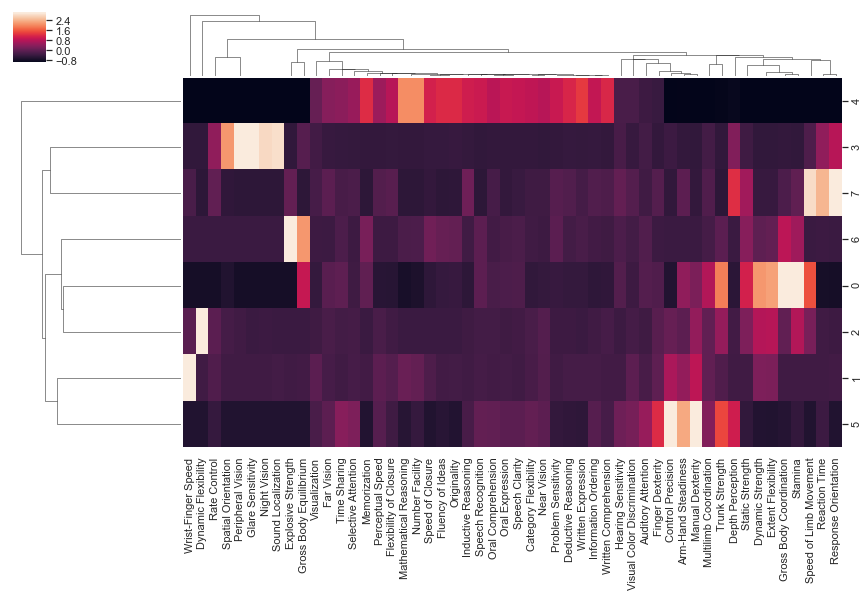

In [20]:
bbb.plot_features(vertical=False)

In [35]:
sva = Svd(aaa.X('fte'))
a1 = sva.s.cumsum()
sva.ns = a1/a1[-1]
limit = 0.9
np.argmin(np.square(sva.ns - limit))

18

In [34]:
np.argmin(np.square(sva.ns - limit))

18

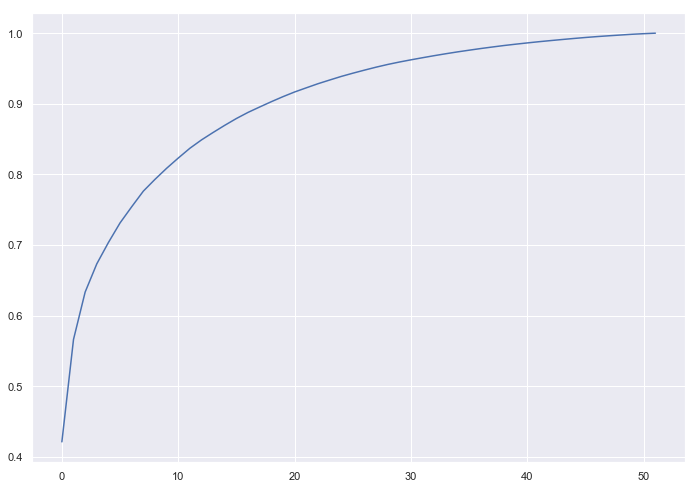

In [28]:
plt.plot(sva.ns)

In [28]:
## Title Keyword Analysis

tt = onet.socp_titles.set_index('SOCP_shave')
tts = np.array(tt['title_vec'].apply(set))
ix = tt.index.values

def in_common(step):
    df = pd.DataFrame(np.array([ix,np.roll(ix,step)]).T)
    df['and'] = tts & np.roll(tts,step)
    return df

corr = pd.concat([in_common(n) for n in range(len(ix))])
corr_mat = corr.set_index([1,0]).unstack()

In [70]:
np.zeros(len(keywords))

array([0., 0., 0., ..., 0., 0., 0.])

In [71]:
tt = onet.socp_titles.set_index('SOCP_shave')[['title_vec']]
keywords = np.array(list(set(tt['title_vec'].apply(list).sum())))
to_numbers = dict(zip(keywords,range(len(keywords))))

def k2n(keywords):
    return list(map(to_numbers.get,keywords))
tt['position']=tt['title_vec'].apply(k2n)

v0 = np.zeros(len(keywords))




In [ ]:
df @ df.T
    

In [232]:
np.array([tt.index,tt['title_vec']]).T

array([['11101100', list(['chief', 'executive'])],
       ['11101103', list(['chief', 'sustainability', 'officer'])],
       ['11102100', list(['general', 'operation', 'manager'])],
       ...,
       ['55301700', list(['radar', 'sonar', 'technician'])],
       ['55301800', list(['special', 'force'])],
       ['55301900',
        list(['military', 'enlisted', 'tactical', 'operation', 'air', 'weapon', 'specialist', 'crew', 'member'])]],
      dtype=object)

In [207]:
aaa = onet.socp_titles.set_index('SOCP_shave')['title_vec']

In [195]:
bbb=list(set(aaa.sum()))

In [245]:
import networkx as nx
from collections import defaultdict 
dic = tt['title_vec'].apply(set).apply(list).to_dict()
graph = nx.from_dict_of_lists(dic)

In [288]:
key_list = sorted(list(set(tt['title_vec'].sum())))
d = pd.DataFrame(key_list)
numbers = d.index
keys = d.values.flatten()
key_to_number = dict(zip(keys,numbers))
number_to_key = dict(zip(numbers,keys))
dic_list = 'lambda lst: [key_to_number[key] for key in lst]'
tt['title_vec'].apply(eval(dic_list))
    

SOCP_shave
11101100                                         [187, 388]
11101103                                   [187, 1074, 735]
11102100                                    [462, 741, 634]
11103100                                              [593]
11201100                                     [19, 864, 634]
11201101                                         [482, 643]
11202100                                         [644, 634]
11202200                                         [963, 634]
11203100                               [876, 923, 451, 634]
11301100                                     [15, 989, 634]
11302100                              [224, 538, 1078, 634]
11303100                                         [417, 634]
11303101                                        [1134, 240]
11303102                               [417, 634, 134, 291]
11305100                                    [535, 858, 634]
11305101                              [883, 238, 1078, 634]
11305102                     

In [286]:
tt['title_vec'].apply(lambda lst: [key_to_number[key] for key in lst])

SOCP_shave
11101100                                         [187, 388]
11101103                                   [187, 1074, 735]
11102100                                    [462, 741, 634]
11103100                                              [593]
11201100                                     [19, 864, 634]
11201101                                         [482, 643]
11202100                                         [644, 634]
11202200                                         [963, 634]
11203100                               [876, 923, 451, 634]
11301100                                     [15, 989, 634]
11302100                              [224, 538, 1078, 634]
11303100                                         [417, 634]
11303101                                        [1134, 240]
11303102                               [417, 634, 134, 291]
11305100                                    [535, 858, 634]
11305101                              [883, 238, 1078, 634]
11305102                     

In [296]:
dic
df2 = pd.DataFrame.from_dict(dic, orient='index')
df2 = df2.stack().reset_index()
df2.level_1=1
df3 = df2.pivot(index='level_0',columns=0,values='level_1').fillna(0)

In [307]:
aaa = Archetypes(df3,6)
aaa.occ.fillna(0).apply(max)

0    1.000000
1         inf
2    1.000000
3    1.000000
4    1.000000
5         inf
dtype: float64

In [309]:
bbb = Svd(df3)

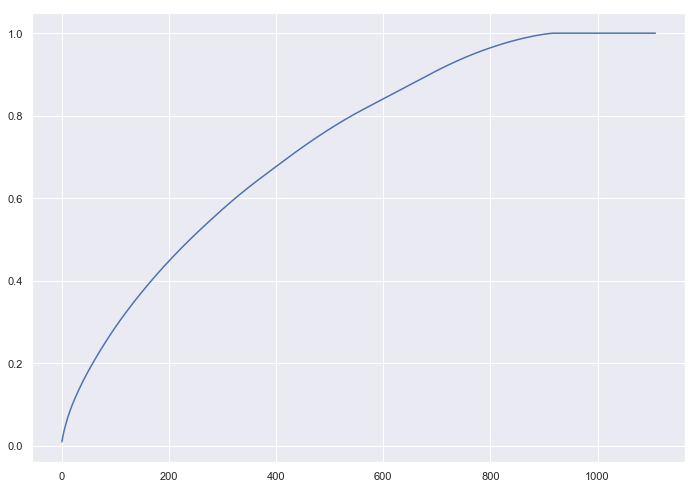

In [323]:
c=bbb.s.cumsum()
plt.plot(c/c.max())

In [5]:
census.data('New Jersey')

csv_pnj.zip: 0.00B [00:00, ?B/s]

*** Downloading New Jersey ACS/PUMS dataset from US Census...


csv_pnj.zip: 70.9MB [01:29, 614kB/s] 


*** Reformatting...
*** Complete.


,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80,SOCP_shave
0,P,2013000000049,2,1,301,1,34,1061971,15,89,...,5,16,15,4,14,29,23,31,27,132011
1,P,2013000000049,2,2,301,1,34,1061971,17,87,...,5,20,17,5,16,30,35,33,32,NaN
2,P,2013000000073,2,1,102,1,34,1061971,16,69,...,30,16,18,16,31,1,1,2,16,NaN
3,P,2013000000166,2,1,1402,1,34,1061971,21,36,...,6,26,20,6,21,34,36,37,39,NaN
4,P,2013000000210,2,1,903,1,34,1061971,9,39,...,18,9,11,11,16,8,9,10,14,119030
5,P,2013000000210,2,2,903,1,34,1061971,9,36,...,12,9,11,10,17,10,13,8,17,519061
6,P,2013000000210,2,3,903,1,34,1061971,7,4,...,10,8,8,6,12,8,9,7,11,NaN
7,P,2013000000210,2,4,903,1,34,1061971,7,1,...,10,9,9,6,12,7,10,7,10,NaN
8,P,2013000000313,2,1,1501,1,34,1061971,10,43,...,9,3,18,16,3,10,10,3,19,131070
9,P,2013000000430,2,1,305,1,34,1061971,13,47,...,4,13,4,3,14,12,11,11,3,411012


In [6]:
onet.toc

<bound method Onet.toc of <__main__.Onet object at 0x10973f240>>

In [7]:
onet.toc()

,name,extension
1,Read Me,txt
2,Green DWA Reference,xlsx
3,Scales Reference,xlsx
4,Occupation Data,xlsx
5,Task Statements,xlsx
6,Sample of Reported Titles,xlsx
7,IWA Reference,xlsx
8,Career Starters Matrix,xlsx
9,Alternate Titles,xlsx
10,Green Occupations,xlsx


In [12]:
onet.matrix('Work Values')

,O*NET-SOC Code,Title,Element ID,Element Name,Scale ID,Scale Name,Data Value,Date,Domain Source,SOCP_shave
0,11-1011.00,Chief Executives,1.B.2.a,Achievement,EX,Extent,6.33,06/2008,Analyst,111011
1,11-1011.00,Chief Executives,1.B.2.b,Working Conditions,EX,Extent,6.33,06/2008,Analyst,111011
2,11-1011.00,Chief Executives,1.B.2.c,Recognition,EX,Extent,7.00,06/2008,Analyst,111011
3,11-1011.00,Chief Executives,1.B.2.d,Relationships,EX,Extent,5.00,06/2008,Analyst,111011
4,11-1011.00,Chief Executives,1.B.2.e,Support,EX,Extent,5.33,06/2008,Analyst,111011
5,11-1011.00,Chief Executives,1.B.2.f,Independence,EX,Extent,7.00,06/2008,Analyst,111011
6,11-1011.00,Chief Executives,1.B.2.g,First Work Value High-Point,VH,Work Value High-Point,3.00,06/2008,Analyst,111011
7,11-1011.00,Chief Executives,1.B.2.h,Second Work Value High-Point,VH,Work Value High-Point,6.00,06/2008,Analyst,111011
8,11-1011.00,Chief Executives,1.B.2.i,Third Work Value High-Point,VH,Work Value High-Point,1.00,06/2008,Analyst,111011
9,11-1011.03,Chief Sustainability Officers,1.B.2.a,Achievement,EX,Extent,6.67,07/2012,Analyst,111011


In [9]:
datadic.census_variable_definitions

{'ACCESS': 'Access to the Internet',
 'ACR': 'Lot size',
 'ADJHSG': 'Adjustment factor for housing dollar amounts (6 implied decimal places)',
 'ADJINC': 'Adjustment factor for income and earnings dollar amounts (6 implied decimal places)',
 'AGEP': 'Age',
 'AGS': 'Sales of Agriculture Products (yearly sales, no adjustment factor is applied)',
 'ANC': 'Ancestry recode',
 'ANC1P': 'Recoded Detailed Ancestry - first entry',
 'ANC2P': 'Recoded Detailed Ancestry - second entry',
 'BATH': 'Bathtub or shower',
 'BDSP': 'Number of bedrooms',
 'BLD': 'Units in structure',
 'BROADBND': 'Cellular data plan for a smartphone or other mobile device',
 'CIT': 'Citizenship status',
 'CITWP': 'Year of naturalization write-in',
 'COMPOTHX': 'Other computer equipment',
 'CONP': 'Condo fee (monthly amount, use ADJHSG to adjust CONP to constant dollars)',
 'COW': 'Class of worker',
 'DDRS': 'Self-care difficulty',
 'DEAR': 'Hearing difficulty',
 'DECADE': 'Decade of entry',
 'DEYE': 'Vision difficulty',
 

In [17]:
datadic.census_about(' national')

,NAME,RT,C,1,Record Type,Unnamed: 5,Unnamed: 6
2977,VAL,INDP,C,4,9870,9870,MIL-Military Reserves Or National Guard
3936,VAL,NAICSP,C,8,928110P7,928110P7,MIL-Military Reserves Or National Guard


In [15]:
census.data('Maine')[['FCITP']]

,FCITP
0,0
1,0
2,0
3,0
4,0
5,1
6,0
7,0
8,0
9,0
